# One Pixel Attack for Fooling Deep Neural Networks
An implementation of the procedure described in https://arxiv.org/abs/1710.08864.

## Setup

In [2]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import math

from pathlib import Path
from tensorboardX import SummaryWriter
from torchvision import datasets, transforms, models
from tqdm import tqdm

writer = SummaryWriter()
sns.set()
sns.set_style("dark")
sns.set_palette("muted")
sns.set_color_codes("muted")

### CUDA

In [3]:
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
LOADER_KWARGS = {'num_workers': 1, 'pin_memory': True} if torch.cuda.is_available() else {'num_workers': 4}
print("CUDA Available:", torch.cuda.is_available())

CUDA Available: True


## Train CIFAR VGG16 Model

### Model Definition

In [4]:
cifar_model = models.vgg11(pretrained=True, init_weights=False)
cifar_model.classifier = nn.Sequential(
        nn.Linear(25088, 4096),
        nn.ReLU(True),
        nn.Dropout(),
        nn.Linear(4096, 2048),
        nn.ReLU(True),
        nn.Dropout(),
        nn.Linear(2048, 10),
    )
cifar_model = cifar_model.to(DEVICE)
print(cifar_model)

Downloading: "https://download.pytorch.org/models/vgg11-8a719046.pth" to C:\Users\deadf/.cache\torch\hub\checkpoints\vgg11-8a719046.pth


  0%|          | 0.00/507M [00:00<?, ?B/s]

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): ReLU(inplace=True)
    (5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU(inplace=True)
    (8): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): ReLU(inplace=True)
    (10): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (11): Conv2d(256, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (12): ReLU(inplace=True)
    (13): Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (14): ReLU(inplace=True)
    (15): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
 

### Dataloading

In [5]:
BATCH_SIZE = 128
TRAIN_COUNT = 40_000
VAL_COUNT = 10_000
TEST_COUNT = 10_000

train_transform = transforms.Compose([
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
])

test_transform = transforms.ToTensor()

train_set = datasets.CIFAR10(root='./dataset', train=True, download=True, transform=train_transform)
train_set = torch.utils.data.dataset.Subset(train_set, range(0,TRAIN_COUNT))
train_loader = torch.utils.data.DataLoader(train_set, batch_size=BATCH_SIZE, shuffle=True, **LOADER_KWARGS)

val_set = datasets.CIFAR10(root='./dataset', train=True, download=True, transform=test_transform)
val_set = torch.utils.data.dataset.Subset(val_set, range(TRAIN_COUNT,TRAIN_COUNT+VAL_COUNT))
val_loader = torch.utils.data.DataLoader(val_set, batch_size=BATCH_SIZE, shuffle=False, **LOADER_KWARGS)

test_set = datasets.CIFAR10(root='./dataset', train=False, download=True, transform=test_transform)
test_loader = torch.utils.data.DataLoader(test_set, batch_size=BATCH_SIZE, shuffle=False, **LOADER_KWARGS)

Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified


### Test and Validation Function

In [6]:
def test(epoch=None, is_validation=False):
    cifar_model.eval()
    loader = val_loader if is_validation else test_loader
    test_loss = 0
    test_correct = 0
    with torch.no_grad():
        for batch_idx, (inputs, targets) in enumerate(loader):
            inputs, targets = inputs.to(DEVICE), targets.to(DEVICE)
            outputs = cifar_model(inputs)
            test_loss += F.cross_entropy(outputs, targets, size_average=False).item()
            test_correct += outputs.max(1)[1].eq(targets).sum().item()
    if is_validation:
        writer.add_scalar('logs/val_loss', test_loss/len(loader.dataset), epoch)
        writer.add_scalar('logs/val_acc', test_correct/len(loader.dataset), epoch)
    else:
        print("Test Accuracy: {}/{}".format(test_correct, len(loader.dataset)))

### Train Function

In [7]:
optimizer = optim.Adam(cifar_model.classifier.parameters())

# Training
def train(epoch):
    cifar_model.train()
    epoch_loss = 0
    epoch_correct = 0
    for batch_idx, (inputs, targets) in enumerate(tqdm(train_loader)):
        inputs, targets = inputs.to(DEVICE), targets.to(DEVICE)
        optimizer.zero_grad()
        outputs = cifar_model(inputs)
        loss = F.cross_entropy(outputs, targets)
        loss.backward()
        optimizer.step()
        batch_correct = outputs.max(1)[1].eq(targets).sum().item()
        epoch_loss += loss.item()
        epoch_correct += batch_correct
        writer.add_scalar('logs/train_loss', loss.item(), epoch*len(train_loader) + batch_idx)
        writer.add_scalar('logs/train_acc', batch_correct / targets.size(0), epoch*len(train_loader) + batch_idx)
    test(epoch, is_validation=True)

### Train Model and Store Weights (or Load Weights)

In [8]:
TRAIN_EPOCHS = 100
WEIGHTS_PATH = Path("./vgg_cifar_weights.pt")

if WEIGHTS_PATH.is_file():
    cifar_model.load_state_dict(torch.load(WEIGHTS_PATH))
    print("Loaded weights from file:", WEIGHTS_PATH)
else:
    for epoch in range(TRAIN_EPOCHS):
        train(epoch)
    torch.save(cifar_model.state_dict(), WEIGHTS_PATH)

100%|██████████| 313/313 [00:20<00:00, 15.27it/s]
c:\Users\deadf\anaconda3\envs\pytorch\lib\site-packages\torch\nn\_reduction.py:42: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
100%|██████████| 313/313 [00:15<00:00, 20.38it/s]


### Test Model Accuracy

In [9]:
test()

Test Accuracy: 6401/10000


## Attack CIFAR Model

In [10]:
CIFAR_LABELS = ('airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

def show(img):
    npimg = img.cpu().numpy()
    plt.imshow(np.transpose(npimg, (1,2,0)), interpolation='nearest')

def tell(img, label, model, target_label=None):
    print("True Label:", CIFAR_LABELS[label], label)
    print("Prediction:", CIFAR_LABELS[model(img.unsqueeze(0)).max(-1)[1]], model(img.unsqueeze(0)).max(-1)[1][0].item())
    print("Label Probabilities:", F.softmax(model(img.unsqueeze(0)).squeeze(), dim=0))
    print("True Label Probability:", F.softmax(model(img.unsqueeze(0)).squeeze(), dim=0)[label].item())
    if target_label is not None:
        print("Target Label Probability:", F.softmax(model(img.unsqueeze(0)).squeeze(), dim=0)[target_label].item())

### Prediction

True Label: truck 9
Prediction: truck 9
Label Probabilities: tensor([6.2412e-08, 3.1746e-05, 1.1975e-16, 5.4310e-13, 1.1331e-16, 8.2030e-16,
        3.0445e-22, 1.3908e-11, 3.1622e-07, 9.9997e-01], device='cuda:0',
       grad_fn=<SoftmaxBackward0>)
True Label Probability: 0.9999679327011108


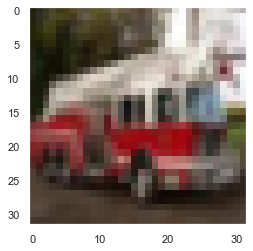

In [11]:
test_img, test_label = test_set[350]
test_img = test_img.to(DEVICE)
show(test_img)
tell(test_img, test_label, cifar_model)

### Perturbation

Perturbation: [0.6  0.6  0.   0.   0.75]
True Label: truck 9
Prediction: truck 9
Label Probabilities: tensor([2.6588e-08, 8.3749e-06, 1.7446e-17, 2.0132e-13, 5.6586e-17, 1.8601e-16,
        2.0406e-23, 4.3589e-12, 1.9776e-07, 9.9999e-01], device='cuda:0',
       grad_fn=<SoftmaxBackward0>)
True Label Probability: 0.9999914169311523


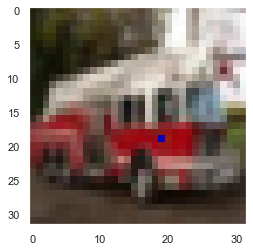

In [12]:
def perturb(p, img):
    # Elements of p should be in range [0,1]
    img_size = img.size(1) # C x _H_ x W, assume H == W
    p_img = img.clone()
    xy = (p[0:2].copy() * img_size).astype(int)
    xy = np.clip(xy, 0, img_size-1)
    rgb = p[2:5].copy()
    rgb = np.clip(rgb, 0, 1)
    p_img[:,xy[0],xy[1]] = torch.from_numpy(rgb)
    return p_img

def visualize_perturbation(p, img, label, model, target_label=None):
    p_img = perturb(p, img)
    print("Perturbation:", p)
    show(p_img)
    tell(p_img, label, model, target_label)

visualize_perturbation(np.array([0.6,0.6,0,0,0.75]), test_img, test_label, cifar_model)

### Untargeted and Targeted Attacks

Target Probability [Iteration 0]: 0.9531249403953552
Target Probability [Iteration 10]: 0.9531249403953552
Target Probability [Iteration 20]: 0.9338660836219788
Target Probability [Iteration 30]: 0.9032151699066162
Target Probability [Iteration 40]: 0.8882888555526733
Target Probability [Iteration 50]: 0.8882888555526733
Target Probability [Iteration 60]: 0.8882888555526733
Target Probability [Iteration 70]: 0.8819152116775513
Target Probability [Iteration 80]: 0.8819152116775513
Target Probability [Iteration 90]: 0.8819152116775513
Target Probability [Iteration 100]: 0.880435585975647
Target Probability [Iteration 110]: 0.8797914981842041
Target Probability [Iteration 120]: 0.8786770105361938
Target Probability [Iteration 130]: 0.8777498602867126
Target Probability [Iteration 140]: 0.8769066333770752
Target Probability [Iteration 150]: 0.8765286803245544
Target Probability [Iteration 160]: 0.8763085603713989
Target Probability [Iteration 170]: 0.8761744499206543
Target Probability [It

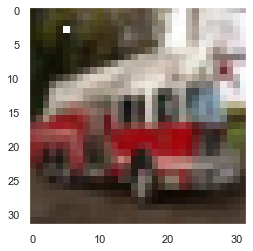

In [14]:
def evaluate(candidates, img, label, model):
    preds = []
    model.eval()
    with torch.no_grad():
        for i, xs in enumerate(candidates):
            p_img = perturb(xs, img)
            preds.append(F.softmax(model(p_img.unsqueeze(0)).squeeze(), dim=0)[label].item())
    return np.array(preds)

def evolve(candidates, F=0.5, strategy="clip"):
    gen2 = candidates.copy()
    num_candidates = len(candidates)
    for i in range(num_candidates):
        x1, x2, x3 = candidates[np.random.choice(num_candidates, 3, replace=False)]
        x_next = (x1 + F*(x2 - x3))
        if strategy == "clip":
            gen2[i] = np.clip(x_next, 0, 1)
        elif strategy == "resample":
            x_oob = np.logical_or((x_next < 0), (1 < x_next))
            x_next[x_oob] = np.random.random(5)[x_oob]
            gen2[i] = x_next
    return gen2

def attack(model, img, true_label, target_label=None, iters=300, pop_size=400, verbose=True):
    # Targeted: maximize target_label if given (early stop > 50%)
    # Untargeted: minimize true_label otherwise (early stop < 5%)
    candidates = np.random.random((pop_size,5))
    candidates[:,2:5] = np.clip(np.random.normal(0.5, 0.5, (pop_size, 3)), 0, 1)
    is_targeted = target_label is not None
    label = target_label if is_targeted else true_label
    fitness = evaluate(candidates, img, label, model)
    
    def is_success():
        return (is_targeted and fitness.max() > 0.5) or ((not is_targeted) and fitness.min() < 0.05)
    
    for iteration in range(iters):
        # Early Stopping
        if is_success():
            break
        if verbose and iteration%10 == 0: # Print progress
            print("Target Probability [Iteration {}]:".format(iteration), fitness.max() if is_targeted else fitness.min())
        # Generate new candidate solutions
        new_gen_candidates = evolve(candidates, strategy="resample")
        # Evaluate new solutions
        new_gen_fitness = evaluate(new_gen_candidates, img, label, model)
        # Replace old solutions with new ones where they are better
        successors = new_gen_fitness > fitness if is_targeted else new_gen_fitness < fitness
        candidates[successors] = new_gen_candidates[successors]
        fitness[successors] = new_gen_fitness[successors]
    best_idx = fitness.argmax() if is_targeted else fitness.argmin()
    best_solution = candidates[best_idx]
    best_score = fitness[best_idx]
    if verbose:
        visualize_perturbation(best_solution, img, true_label, model, target_label)
    return is_success(), best_solution, best_score

# Untargeted attack
_ = attack(cifar_model, test_img, test_label)

In [15]:
# Targeted attack
# This is much harder/costlier than an untargeted attack
# For time reasons, targeted attacks below use 20 iterations
targeted_results = {}
for idx in range(len(CIFAR_LABELS)):
    if idx != test_label:
        targeted_results[idx] = attack(cifar_model, test_img, test_label, target_label=idx, iters=20, verbose=False)
        print(CIFAR_LABELS[idx], idx, targeted_results[idx][0], targeted_results[idx][2])
    else:
        print(CIFAR_LABELS[idx], idx, "True Label")

airplane 0 False 0.001138672698289156
automobile 1 False 0.10495683550834656
bird 2 False 5.9044772626748454e-08
cat 3 False 9.762346735442406e-07
deer 4 False 1.3773056473098677e-08
dog 5 False 2.168134827229551e-08
frog 6 False 4.86134243971037e-10
horse 7 False 1.3928165571996942e-05
ship 8 False 0.02550469897687435
truck 9 True Label
